# 第7章: 単語ベクトル
>単語の意味を実ベクトルで表現する単語ベクトル（単語埋め込み）に関して，以下の処理を行うプログラムを作成せよ

## 60. 単語ベクトルの読み込みと表示
>Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル（300万単語・フレーズ，300次元）をダウンロードし，”United States”の単語ベクトルを表示せよ．ただし，”United States”は内部的には”United_States”と表現されていることに注意せよ

In [4]:
!gunzip GoogleNews-vectors-negative300.bin.gz

.binはバイナリファイルなので, openコマンドのオプションにバイナリのbを加えた'rb'モードを渡して開く

In [8]:
with open('GoogleNews-vectors-negative300.bin', 'rb') as f:
    data_set = f.read()
    
print(type(data_set))
print(type(data_set.decode('UTF-16')))
print(len(data_set))

<class 'bytes'>


UnicodeDecodeError: 'utf-16-le' codec can't decode bytes in position 46-47: illegal encoding

decodeがうまくいかない.　=>　どうやら, こういう形式のファイルを読みこむライブラリがあるっぽい => gensimとかmagnitude

gensim使ってみよう  

### Gensimとは
>`topic modelling for humans` = 様々なトピックモデルを実装したライブラリ.LDAとかが実装されている(word2vecみたいなword embedding手法の実装もされている)

In [1]:
import gensim
# KeyedVecotrsで辞書形式でベクトルを格納, load_word2vec_formatでword2vecのフォーマットでデータを読み込み. バイナリファイルなのでbinary=True
wv = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [3]:
print(type(wv))
# 以下のようにして表示したい単語ベクトル名を渡すと, ベクトルが返ってくる
print(wv['United_States'])

<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
[-3.61328125e-02 -4.83398438e-02  2.35351562e-01  1.74804688e-01
 -1.46484375e-01 -7.42187500e-02 -1.01562500e-01 -7.71484375e-02
  1.09375000e-01 -5.71289062e-02 -1.48437500e-01 -6.00585938e-02
  1.74804688e-01 -7.71484375e-02  2.58789062e-02 -7.66601562e-02
 -3.80859375e-02  1.35742188e-01  3.75976562e-02 -4.19921875e-02
 -3.56445312e-02  5.34667969e-02  3.68118286e-04 -1.66992188e-01
 -1.17187500e-01  1.41601562e-01 -1.69921875e-01 -6.49414062e-02
 -1.66992188e-01  1.00585938e-01  1.15722656e-01 -2.18750000e-01
 -9.86328125e-02 -2.56347656e-02  1.23046875e-01 -3.54003906e-02
 -1.58203125e-01 -1.60156250e-01  2.94189453e-02  8.15429688e-02
  6.88476562e-02  1.87500000e-01  6.49414062e-02  1.15234375e-01
 -2.27050781e-02  3.32031250e-01 -3.27148438e-02  1.77734375e-01
 -2.08007812e-01  4.54101562e-02 -1.23901367e-02  1.19628906e-01
  7.44628906e-03 -9.03320312e-03  1.14257812e-01  1.69921875e-01
 -2.38281250e-01 -2.79541016e-02

## 61. 単語の類似度
>“United States”と”U.S.”のコサイン類似度を計算せよ

In [4]:
wv.similarity('United_States', 'U.S.')

0.73107743

ちなみにコサイン類似度は以下の数式によって算出されるもので, -1~1の間の値をとり, `2本のベクトルがどれくらい同じ向きを向いているか`を表す指標.   

$$
\vec{a}=(a_1, a_2, ...)と\vec{b}=(b_1, b_2, ...)があるとき  
\frac{a_1 b_1 + a_2 b_2 + .. .+ a_n b_n }{ \sqrt{{a_1}^2+...+{a_n}^2} \sqrt{{b_1}^2+...+{b_n}^2} }
$$  
  
コサイン類似度が1に近いほど2本のベクトルは同じ向きに近い.  
コサイン類似度が-1に近いほど2本のベクトルは逆向きに近い.

## 62. 類似度の高い単語10件
>“United States”とコサイン類似度が高い10語と，その類似度を出力せよ

In [5]:
wv.most_similar('United_States')

[('Unites_States', 0.7877247333526611),
 ('Untied_States', 0.7541369795799255),
 ('United_Sates', 0.7400725483894348),
 ('U.S.', 0.7310774326324463),
 ('theUnited_States', 0.6404394507408142),
 ('America', 0.6178410053253174),
 ('UnitedStates', 0.6167312860488892),
 ('Europe', 0.613298773765564),
 ('countries', 0.604480504989624),
 ('Canada', 0.6019070744514465)]

類似度上位のものは`Unites_Staes`や`Untied_States`などで, これはUnited_Statesを誤字ったもの...?  
他はAmericaやヨーロッパ, カナダなど確かに関連ありそうな単語になっている

In [6]:
# topn引数でいくつ類似度上位の単語を表示するかを指定できる.
wv.most_similar('United_States', topn=1)

[('Unites_States', 0.7877247333526611)]

## 63. 加法構成性によるアナロジー
>“Spain”の単語ベクトルから”Madrid”のベクトルを引き，”Athens”のベクトルを足したベクトルを計算し，そのベクトルと類似度の高い10語とその類似度を出力せよ

In [7]:
# これもmost_similar使って計算することができる
wv.most_similar(positive=['Spain', 'Athens'], negative=['Madrid'])

[('Greece', 0.689848005771637),
 ('Aristeidis_Grigoriadis', 0.560684859752655),
 ('Ioannis_Drymonakos', 0.5552908778190613),
 ('Greeks', 0.5450686812400818),
 ('Ioannis_Christou', 0.5400862693786621),
 ('Hrysopiyi_Devetzi', 0.5248444080352783),
 ('Heraklio', 0.5207759737968445),
 ('Athens_Greece', 0.516880989074707),
 ('Lithuania', 0.5166866779327393),
 ('Iraklion', 0.5146791338920593)]

`Spain`から首都の`Madrid`を引いて, そこにギリシャの首都である`Athens`を足している.  
類似度の高い単語にはギリシャ関連のものがHitしているのでそれっぽい結果になっている.

In [8]:
#　おまけ
from pprint import pprint
data = wv.most_similar(positive=['Soccer', 'Bat'], negative=['Ball'])

print(type(data))
print(len(data))
pprint(data)

<class 'list'>
10
[('Lacrosse', 0.4714975953102112),
 ('Baseball_#K#_Fantasy', 0.46438997983932495),
 ('Baseball', 0.45301195979118347),
 ('Baseball_#K#_2K_Sports', 0.44028663635253906),
 ('soccer', 0.4369726777076721),
 ('Soccer_MetroStars', 0.420335590839386),
 ('Football', 0.4032299518585205),
 ('Futbol', 0.4001754820346832),
 ('Soccers', 0.3987915515899658),
 ('Softball', 0.3983624577522278)]


このように単語同士の足し算引き算によってそれに対応するような他の単語を構成できる性質を`加法構成法`と呼んでいる.  
この性質は特定の単語に依存するものではなく, 単語全般に渡って確認できるっぽい

## 64. アナロジーデータでの実験
>単語アナロジーの評価データをダウンロードし，vec(2列目の単語) - vec(1列目の単語) + vec(3列目の単語)を計算し，そのベクトルと類似度が最も高い単語と，その類似度を求めよ．求めた単語と類似度は，各事例の末尾に追記せよ

In [26]:
!wget -nc http://download.tensorflow.org/data/questions-words.txt

--2020-12-30 12:31:53--  http://download.tensorflow.org/data/questions-words.txt
download.tensorflow.org (download.tensorflow.org) をDNSに問いあわせています... 2404:6800:4004:80d::2010, 172.217.175.80
download.tensorflow.org (download.tensorflow.org)|2404:6800:4004:80d::2010|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 603955 (590K) [text/plain]
`questions-words.txt' に保存中

questions-words.txt 100%[===================>] 589.80K  --.-KB/s 時間 0.1s       

2020-12-30 12:31:54 (5.48 MB/s) - `questions-words.txt' へ保存完了 [603955/603955]



In [9]:
import pandas as pd
category = 'capital-common-countries'    # カテゴリ名の初期値を設定
with open('questions-words.txt') as f, open('calc-words.txt', 'w') as fw:
    for line in f:
        if ':' in line:
            category = line.replace(': ', '').strip('\n')
            print(f'category={category}')
        else:
            data = line.strip('\n').split(' ')
            calc_word, similarity = wv.most_similar(positive=[data[1], data[2]], negative=[data[0]], topn=1)[0]
            print(category, data[0], data[1], data[2], data[3], calc_word, similarity, sep=' ', file = fw)

category=capital-common-countries
category=capital-world
category=currency
category=city-in-state
category=family
category=gram1-adjective-to-adverb
category=gram2-opposite
category=gram3-comparative
category=gram4-superlative
category=gram5-present-participle
category=gram6-nationality-adjective
category=gram7-past-tense
category=gram8-plural
category=gram9-plural-verbs


In [10]:
ana_df = pd.read_table('calc-words.txt', sep=' ', names=['category', 'col1', 'col2', 'col3', 'col4', 'calc_word', 'similarity'], header=None)
ana_df.head()

,category,col1,col2,col3,col4,calc_word,similarity
0,capital-common-countries,Athens,Greece,Baghdad,Iraq,Iraqi,0.635187
1,capital-common-countries,Athens,Greece,Bangkok,Thailand,Thailand,0.713767
2,capital-common-countries,Athens,Greece,Beijing,China,China,0.723578
3,capital-common-countries,Athens,Greece,Berlin,Germany,Germany,0.673462
4,capital-common-countries,Athens,Greece,Bern,Switzerland,Switzerland,0.491975


In [11]:
ana_df.category.value_counts()

capital-world                  4524
city-in-state                  2467
gram6-nationality-adjective    1599
gram7-past-tense               1560
gram3-comparative              1332
gram8-plural                   1332
gram4-superlative              1122
gram5-present-participle       1056
gram1-adjective-to-adverb       992
gram9-plural-verbs              870
currency                        866
gram2-opposite                  812
family                          506
capital-common-countries        506
Name: category, dtype: int64

## 65. アナロジータスクでの正解率
>64の実行結果を用い，意味的アナロジー（semantic analogy）と文法的アナロジー（syntactic analogy）の正解率を測定せよ

In [16]:
# 意味的アナロジーはカテゴリ名にgramが含まれていないやつ,  文法的アナロジーではカテゴリ名にgramが含まれているやつ
df_semantic = ana_df[~(ana_df.category.str.contains('gram'))]
df_syntactic = ana_df[ana_df.category.str.contains('gram')]

semantic_accuracy = len(df_semantic[df_semantic['col4'] == df_semantic['calc_word']]) / len(df_semantic)
syntactic_accuracy = len(df_syntactic[df_syntactic['col4'] == df_syntactic['calc_word']]) / len(df_syntactic)
print(f'意味的アナロジーの正解率{semantic_accuracy}, 文法的アナロジーの正解率{syntactic_accuracy}')

意味的アナロジーの正解率0.7308602999210734, 文法的アナロジーの正解率0.7400468384074942


## 66. WordSimilarity-353での評価
>The WordSimilarity-353 Test Collectionの評価データをダウンロードし，単語ベクトルにより計算される類似度のランキングと，人間の類似度判定のランキングの間のスピアマン相関係数を計算せよ

In [19]:
!wget -nc http://localhost:8888/files/Desktop/nlp100knocks/7%E7%AB%A0/wordsim353.zip

--2020-12-30 20:54:58--  http://localhost:8888/files/Desktop/nlp100knocks/7%E7%AB%A0/wordsim353.zip
localhost (localhost) をDNSに問いあわせています... ::1, 127.0.0.1
localhost (localhost)|::1|:8888 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: /login?next=%2Ffiles%2FDesktop%2Fnlp100knocks%2F7%25E7%25AB%25A0%2Fwordsim353.zip [続く]
--2020-12-30 20:54:58--  http://localhost:8888/login?next=%2Ffiles%2FDesktop%2Fnlp100knocks%2F7%25E7%25AB%25A0%2Fwordsim353.zip
[localhost]:8888 への接続を再利用します。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 9231 (9.0K) [text/html]
`wordsim353.zip' に保存中

wordsim353.zip      100%[===================>]   9.01K  --.-KB/s 時間 0s         

2020-12-30 20:54:58 (109 MB/s) - `wordsim353.zip' へ保存完了 [9231/9231]



In [21]:
!unzip wordsim353.zip

Archive:  wordsim353.zip
  inflating: combined.csv            
  inflating: set1.csv                
  inflating: set2.csv                
  inflating: combined.tab            
  inflating: set1.tab                
  inflating: set2.tab                
  inflating: instructions.txt        


In [22]:
df_combined = pd.read_csv('combined.csv')
df_combined.head()

,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


In [27]:
def calc_similarity(row):
    return wv.similarity(row['Word 1'], row['Word 2'])

df_combined['Calc_sim'] = df_combined.apply(calc_similarity, axis=1)
df_combined.head()

,Word 1,Word 2,Human (mean),Calc_sim
0,love,sex,6.77,0.263938
1,tiger,cat,7.35,0.517296
2,tiger,tiger,10.00,1.000000
3,book,paper,7.46,0.363463
4,computer,keyboard,7.62,0.396392


### スピアマン相関係数
>二つのランキング順位に相関があるかどうかをみることができる.  
例えば, 数学のランキングと英語のランキングに相関があれば, 数学できるやつは英語もできるみたいなことがわかる.素直に相関係数に`順位`という数字を適用したものみたいに考えておいて良さそう.

In [28]:
from scipy.stats import spearmanr
corr, pvalue = spearmanr(df_combined['Human (mean)'], df_combined['Calc_sim'])
print(f'相関係数 = {corr},  P値 = {pvalue}')

相関係数 = 0.7000166486272194,  P値 = 2.86866666051422e-53


### P値とは
>帰無仮説の下で, 実際にデータから計算された統計量よりも極端な統計量が観測される確率.  
つまり, P値が小さいほど今回得られた統計量は偶然ではなく必然と考えて良いとなるっぽい...?

In [29]:
# おまけ  df.corrにmethod='spearman'として引数しても計算できる
df_combined[['Human (mean)', 'Calc_sim']].corr(method='spearman')

,Human (mean),Calc_sim
Human (mean),1.000000,0.700017
Calc_sim,0.700017,1.000000


## 67. k-meansクラスタリング
>国名に関する単語ベクトルを抽出し，k-meansクラスタリングをクラスタ数k=5として実行せよ

In [35]:
from sklearn.cluster import KMeans

# 国に関する情報を持ってるデータを抽出
df_country = ana_df[ana_df.category.isin(['capital-world', 'capital-common-countries', 'currency'])][['col1', 'col2', 'col3', 'col4']]

In [39]:
import numpy as np

# DataFrameのデータを1次元リスト化(単語の重複なし)
country_data_list = list(set(np.ravel(df_country.values.tolist())))
print(len(country_data_list))
pprint(country_data_list)

269
['Bucharest',
 'Turkey',
 'Lebanon',
 'Windhoek',
 'Oslo',
 'Santiago',
 'Brazil',
 'Azerbaijan',
 'Beijing',
 'Hungary',
 'Peru',
 'Syria',
 'Bhutan',
 'Valletta',
 'Tunis',
 'Jakarta',
 'Morocco',
 'Laos',
 'India',
 'Kampala',
 'Minsk',
 'Portugal',
 'Oman',
 'Quito',
 'Belarus',
 'Ecuador',
 'Conakry',
 'Guyana',
 'kuna',
 'Germany',
 'Malaysia',
 'Cambodia',
 'Zagreb',
 'Guinea',
 'Venezuela',
 'Baghdad',
 'Greenland',
 'Nicaragua',
 'England',
 'dinar',
 'Bamako',
 'riel',
 'Pakistan',
 'baht',
 'Rabat',
 'Bishkek',
 'Algiers',
 'Kabul',
 'Kenya',
 'Taipei',
 'Albania',
 'Italy',
 'Europe',
 'Muscat',
 'Gambia',
 'Slovakia',
 'Copenhagen',
 'Spain',
 'Bangkok',
 'peso',
 'Philippines',
 'Romania',
 'litas',
 'Iraq',
 'Islamabad',
 'Jordan',
 'Uzbekistan',
 'Cyprus',
 'Bern',
 'Angola',
 'lev',
 'Sofia',
 'Nicosia',
 'Finland',
 'Belgrade',
 'Manila',
 'Podgorica',
 'Poland',
 'Moldova',
 'Somalia',
 'Liberia',
 'Ljubljana',
 'Dhaka',
 'London',
 'Stockholm',
 'Tashkent',
 'Ma

In [42]:
country_vec = [wv[data] for data in country_data_list]
k_means = KMeans(n_clusters=5, random_state=42).fit_predict(country_vec)
print(len(k_means))
pprint(k_means)

269
array([4, 3, 3, 1, 2, 2, 3, 4, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 1, 4, 3,
       3, 2, 3, 3, 1, 3, 0, 3, 3, 3, 4, 1, 3, 2, 3, 3, 3, 0, 1, 0, 3, 0,
       2, 4, 1, 2, 1, 2, 3, 3, 3, 2, 1, 3, 2, 3, 2, 0, 3, 3, 0, 3, 2, 3,
       3, 3, 2, 3, 0, 4, 4, 3, 4, 2, 4, 3, 3, 1, 1, 4, 2, 2, 2, 4, 1, 1,
       3, 1, 4, 4, 1, 1, 3, 3, 0, 2, 1, 4, 0, 2, 3, 0, 0, 3, 4, 3, 2, 0,
       4, 3, 2, 1, 3, 3, 1, 4, 3, 3, 1, 0, 0, 3, 1, 1, 1, 2, 1, 1, 3, 3,
       1, 4, 3, 2, 4, 2, 3, 1, 3, 1, 4, 3, 2, 1, 2, 3, 3, 2, 1, 1, 2, 2,
       3, 2, 3, 1, 2, 4, 3, 4, 1, 2, 2, 1, 3, 2, 4, 1, 2, 0, 4, 1, 3, 2,
       3, 3, 3, 0, 0, 0, 3, 2, 2, 1, 3, 0, 1, 3, 2, 1, 3, 2, 0, 1, 4, 3,
       2, 3, 4, 3, 3, 3, 3, 1, 3, 2, 1, 2, 0, 4, 1, 4, 3, 2, 3, 3, 4, 2,
       2, 4, 2, 0, 4, 1, 4, 4, 3, 3, 3, 0, 4, 1, 1, 3, 4, 3, 2, 3, 2, 3,
       3, 3, 1, 1, 3, 0, 3, 3, 2, 1, 0, 1, 3, 3, 2, 2, 1, 3, 3, 2, 3, 4,
       3, 2, 3, 3, 3], dtype=int32)


In [51]:
# どの単語がどのクラス分類になっているかを確認
from collections import defaultdict

word_clusters = defaultdict(list)

for clu_num, word in zip(k_means, country_data_list):
    word_clusters[clu_num].append(word)
    
for cluster_num in range(len(word_clusters)):
    print(f'Cluster {cluster_num}')
    print(word_clusters[cluster_num])
    print('==============')

Cluster 0
['kuna', 'dinar', 'riel', 'baht', 'peso', 'litas', 'lev', 'rial', 'yen', 'lats', 'krona', 'forint', 'hryvnia', 'euro', 'krone', 'leu', 'rupee', 'zloty', 'dong', 'ruble', 'dram', 'naira', 'ringgit', 'dollar', 'kwanza']
Cluster 1
['Windhoek', 'Kampala', 'Conakry', 'Guinea', 'Bamako', 'Algiers', 'Kenya', 'Gambia', 'Somalia', 'Liberia', 'Mauritania', 'Dakar', 'Ghana', 'Asmara', 'Mogadishu', 'Nouakchott', 'Mali', 'Banjul', 'Mozambique', 'Lilongwe', 'Luanda', 'Nigeria', 'Namibia', 'Zimbabwe', 'Antananarivo', 'Maputo', 'Niamey', 'Gabon', 'Eritrea', 'Uganda', 'Malawi', 'Madagascar', 'Kigali', 'Accra', 'Gaborone', 'Senegal', 'Monrovia', 'Lusaka', 'Harare', 'Abuja', 'Zambia', 'Botswana', 'Sudan', 'Niger', 'Bujumbura', 'Khartoum', 'Burundi', 'Libreville', 'Rwanda', 'Nairobi']
Cluster 2
['Oslo', 'Santiago', 'Beijing', 'Valletta', 'Tunis', 'Jakarta', 'Quito', 'Baghdad', 'Rabat', 'Kabul', 'Taipei', 'Muscat', 'Copenhagen', 'Bangkok', 'Islamabad', 'Bern', 'Manila', 'Dhaka', 'London', 'Stockh

>Cluster 0  
これは通貨がまとめられてるっぽい

>Cluster 1  
ウガンダ, ナイロビ, ザンビア, ガーナとかあるからアフリカ大陸の国々がまとまってるっぽい

>Cluster 2  
これは東京, ドーハ, パリ, ロンドンとかあるから世界の首都がまとまってるっぽい

>Cluster 3  
トルコ, ブラジル, インド, 日本, エジプト, USAとかあるから, これは世界の国名がまとまってるっぽい

>Cluster 4  
アンカラ(トルコの首都), ブリュッセル(ベルギーの首都), ミンスク(ベラルーシの首都), ソフィア(ブルガリアの首都)とかがあるので, ヨーロッパ地域の首都がまとまっているっぽい...?

## 68. Ward法によるクラスタリング
>国名に関する単語ベクトルに対し，Ward法による階層型クラスタリングを実行せよ．さらに，クラスタリング結果をデンドログラムとして可視化せよ

ウォード法では, 偏差平方和(偏差＝平均との差)に基づいてクラスタリングする.  
全データnをk個のクラスターに分けるとすると, nCk通りの組み合わせが考えられる.このそれぞれの組み合わせにおいて偏差平方和を計算し, これが最小となる組み合わせを採用する.

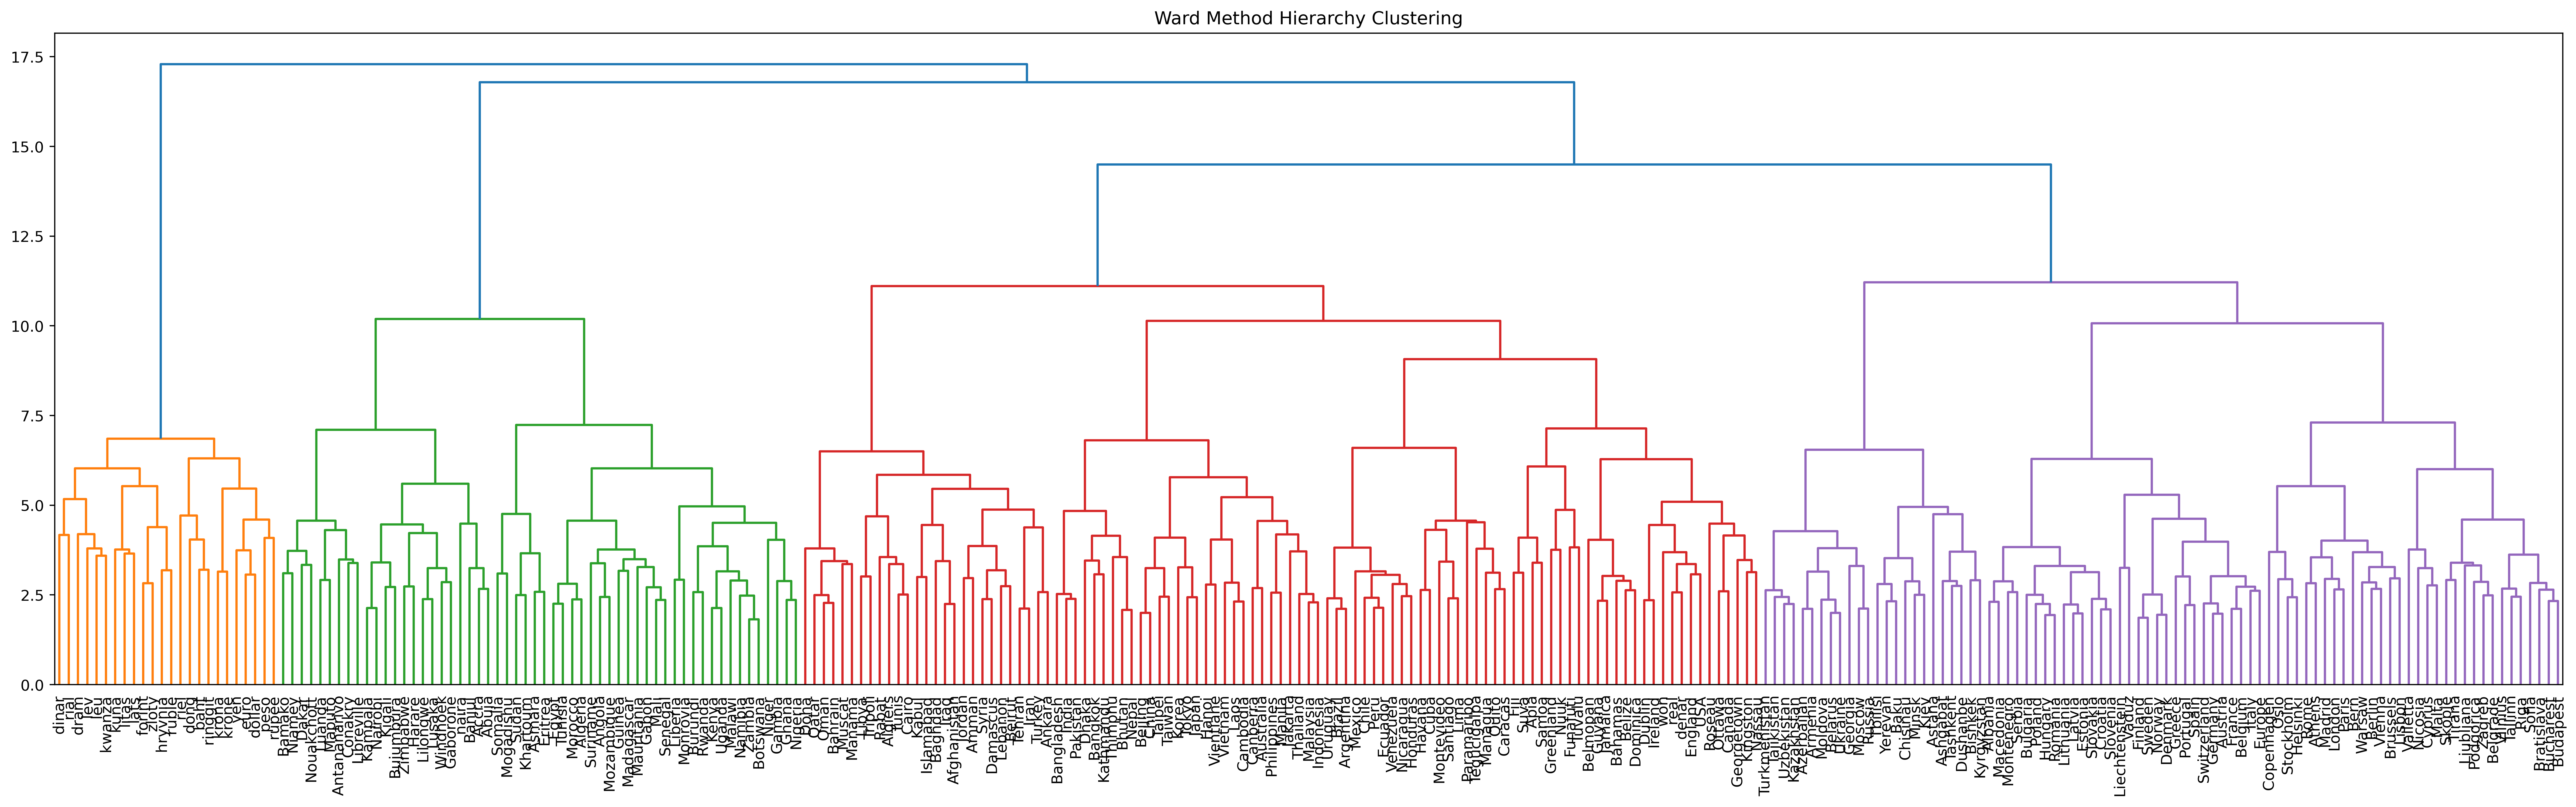

In [57]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(pd.DataFrame(country_vec), method='ward', )
plt.figure(figsize=(30, 8), dpi=400)    # dpiは解像度指定できる.デフォが100
dendrogram(Z, labels=country_data_list,  leaf_font_size=10)
plt.title('Ward Method Hierarchy Clustering')
plt.show()

## 69. t-SNEによる可視化
>ベクトル空間上の国名に関する単語ベクトルをt-SNEで可視化せよ

t-SNE(t-Distributed Stochastic Neighbor Embedding)は高次元データを2次元or3次元に変換して可視化するための**次元削減アルゴリズム**.  
高次元の局所的な構造を非常によく捉えたり, 大極的な構造も可能な限り捉えるといった特徴がある.ただ内部パラメータ(Perplexity)の値によって, 出現するクラスターが大きく異なるなどの扱いにくさもある.

In [58]:
from sklearn.manifold import TSNE

In [59]:
tsne = TSNE(n_components=2).fit_transform(country_vec)   # n_componentsで落とし込む次元数を指定
print(type(tsne))
print(tsne.shape)
print(tsne)

<class 'numpy.ndarray'>
(269, 2)
[[-1.61353626e+01  8.03591430e-01]
 [-9.51703930e+00  5.77859068e+00]
 [ 1.10323648e+01 -5.49546289e+00]
 [ 2.50831165e+01  3.97090745e+00]
 [-9.08648205e+00 -5.56364632e+00]
 [ 2.70991850e+00  9.13177395e+00]
 [ 2.56747723e+00  4.71049976e+00]
 [-1.56357870e+01  6.35503483e+00]
 [-2.43918753e+00 -1.07339144e+01]
 [-8.75301361e+00  1.38608217e+00]
 [ 4.09755278e+00  6.59086657e+00]
 [ 9.88467979e+00 -5.32437801e+00]
 [ 4.40508795e+00 -1.52426004e+01]
 [-5.13579988e+00  7.76556730e+00]
 [ 1.34338560e+01 -7.16823959e+00]
 [ 2.39167571e+00 -1.20394983e+01]
 [ 1.15566235e+01 -1.47666156e+00]
 [-3.25489730e-01 -1.42852736e+01]
 [ 4.74056959e+00 -1.12252350e+01]
 [ 2.26705151e+01  1.81954932e+00]
 [-1.77730064e+01  3.59849453e+00]
 [ 8.96989852e-02  3.97842288e+00]
 [ 5.92271471e+00 -7.46897078e+00]
 [ 3.32087994e+00  1.05665665e+01]
 [-1.41042337e+01  4.59857988e+00]
 [ 4.74031496e+00  6.89363241e+00]
 [ 2.47679615e+01 -3.13828611e+00]
 [ 9.70478439e+00  5.8

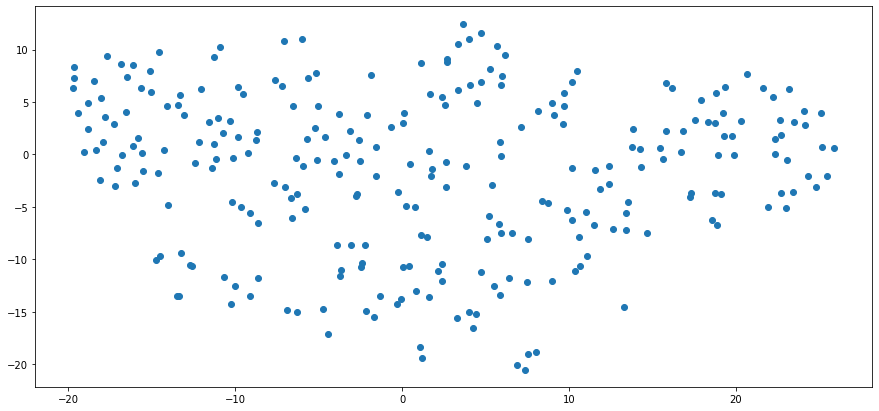

In [62]:
plt.figure(figsize=(15, 7))
plt.scatter(tsne[:, 0], tsne[:, 1])
    
plt.show()

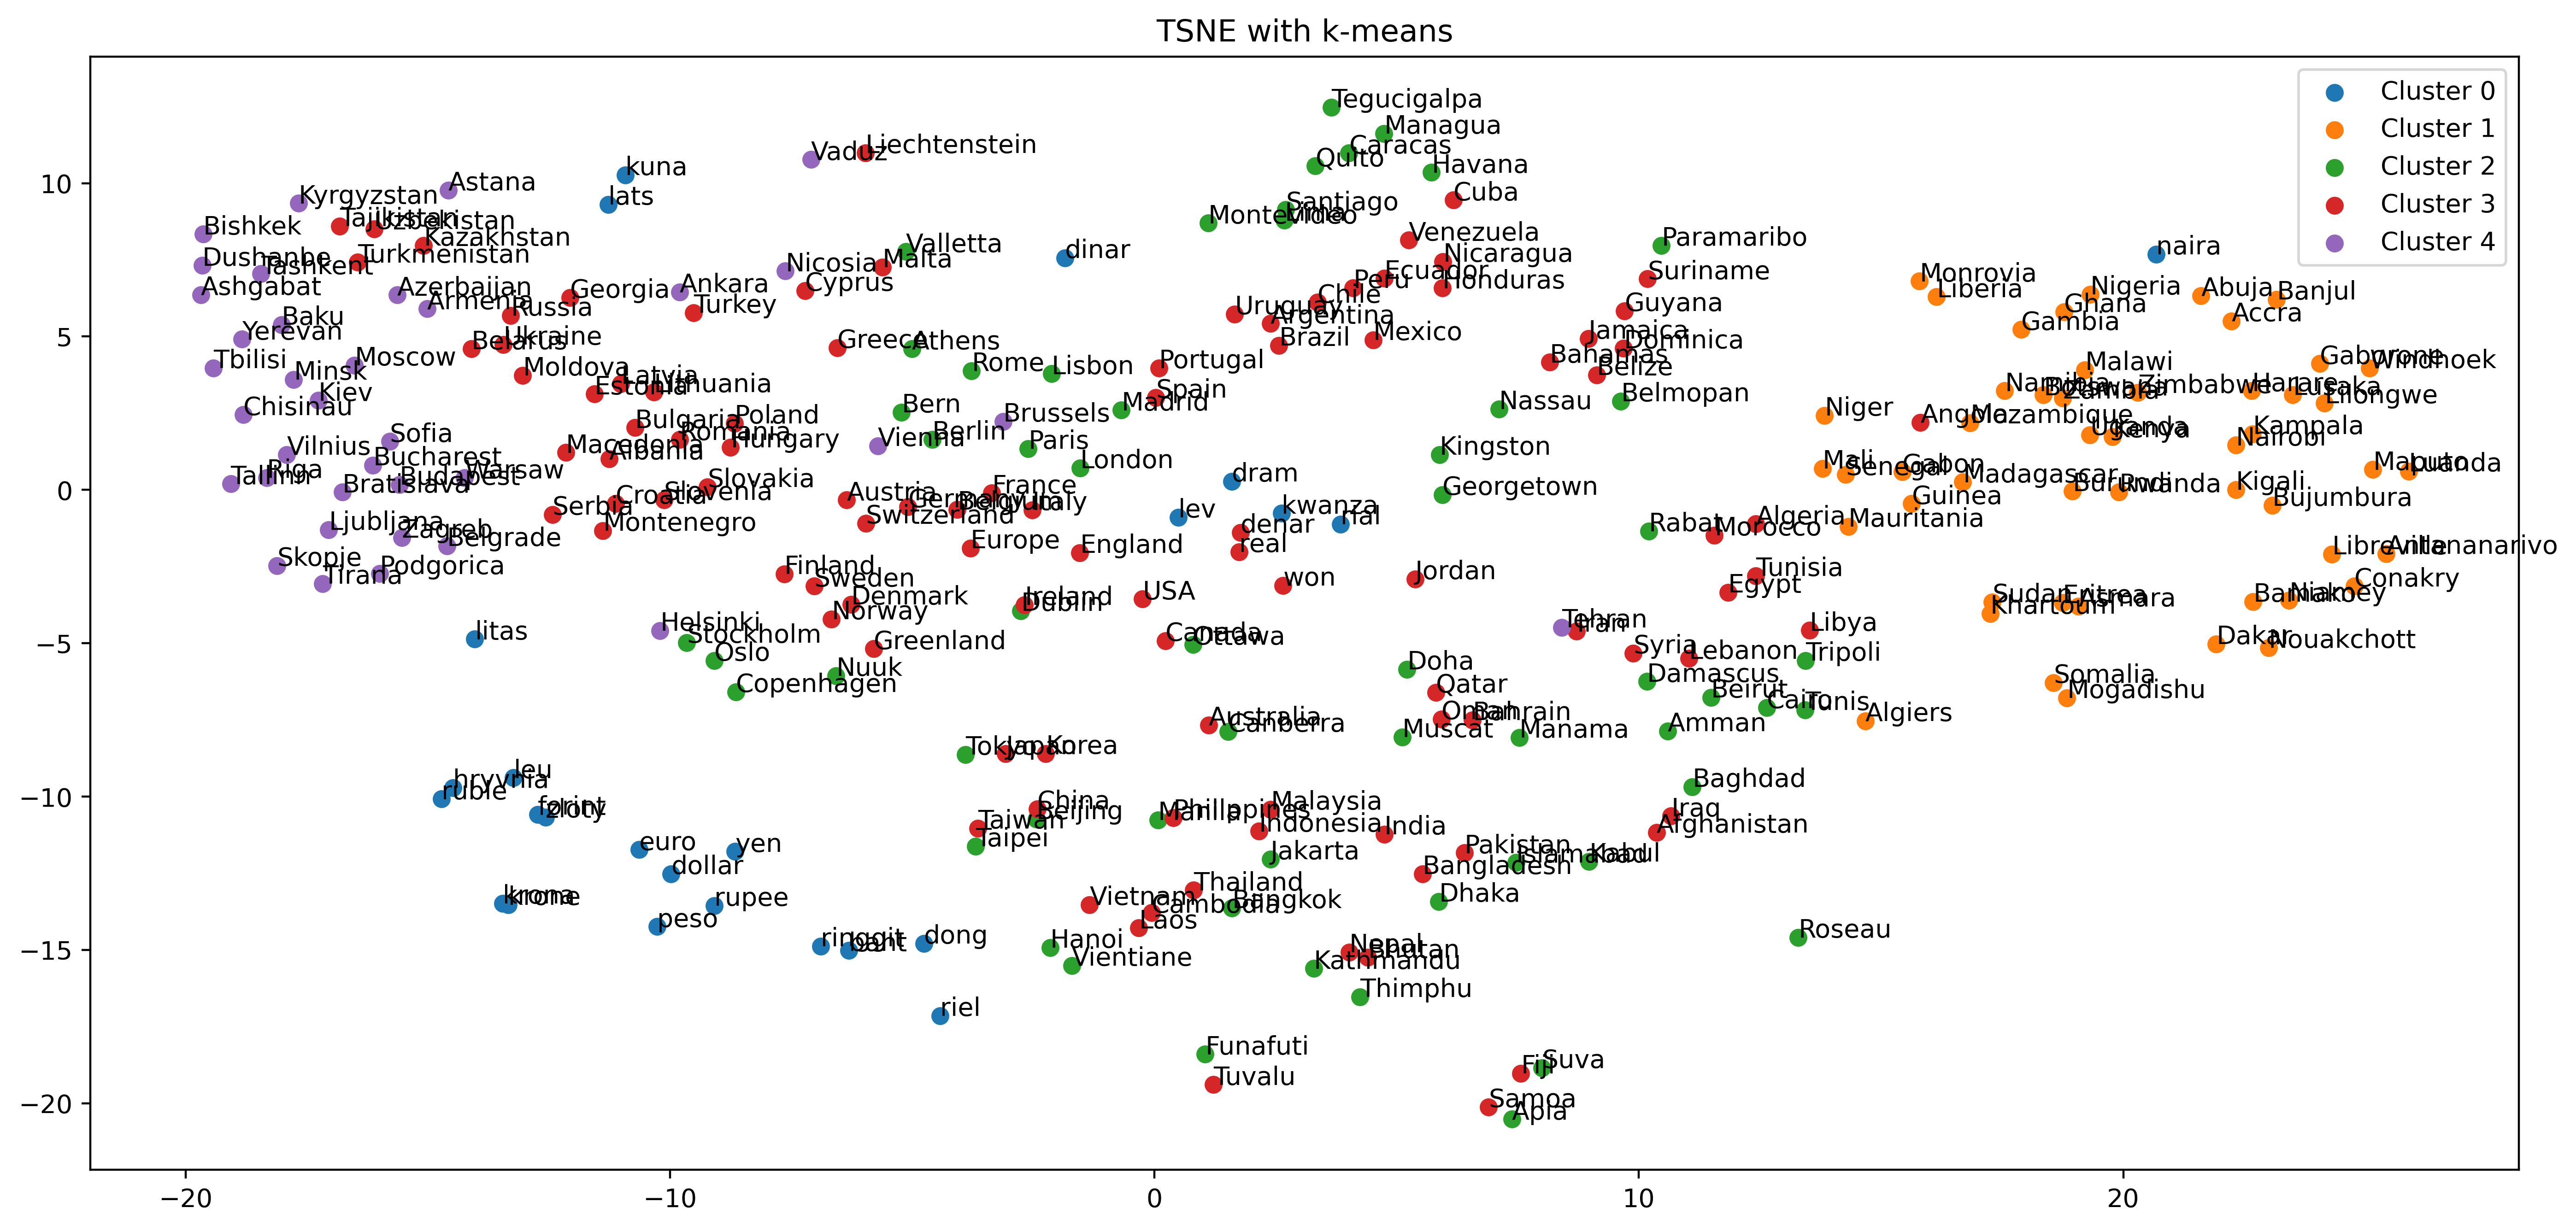

In [72]:
plt.figure(figsize=(17, 8), dpi=400)
for i in range(5):
    plt.scatter(tsne[k_means==i, 0], tsne[k_means==i, 1], label=f'Cluster {i}')
    
for label, vec in zip(country_data_list, tsne):
    plt.annotate(label, vec)
    
plt.legend()
plt.title('TSNE with k-means')
plt.show()